<a href="https://colab.research.google.com/github/thbdnw/conditional_sentences/blob/main/%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install nltk arxiv wikipedia --upgrade

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.4 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=c3e096909ac728f47e7242b0abb96b9b774dbb373730c1193dbd22aa857f947e
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=cc3e4104392f3bf747a6d4b50bcdeffbabfe53108153eec046df48b808e90e0a
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built wikipedia sgmllib3k


In [ ]:
import nltk
nltk.download('brown')
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('punkt_tab')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Извлечение предложений

In [ ]:
from nltk.corpus import brown, gutenberg
from nltk import sent_tokenize

# fiction из Brown
fic_sents = brown.sents(categories='fiction')
# learned из Brown
acad_sents = brown.sents(categories='learned')

# fiction из Gutenberg
gutenberg_sents = []
for book in ['austen-emma.txt','austen-persuasion.txt','carroll-alice.txt']:
    text = gutenberg.raw(book)
    gutenberg_sents += sent_tokenize(text)

# художественный корпус
fiction_sents = [' '.join(s) for s in fic_sents] + gutenberg_sents
# академический корпус
import arxiv, wikipedia
academ_sents = [' '.join(s) for s in acad_sents]
# 1000 abstracts из cs.LG
search = arxiv.Search(query="cat:cs.LG", max_results=1000)
for result in search.results():
    academ_sents += sent_tokenize(result.summary)

<ipython-input-3-4d4d06ab20dd>:22: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Очистка и нормализация

In [ ]:
import re

def clean(sent):
    s = re.sub(r'\s+', ' ', sent)
    return s.strip()

fiction_sents = [clean(s) for s in fiction_sents]
academ_sents    = [clean(s) for s in academ_sents]

Ядро и периферия

In [ ]:
import re

patterns = {
    'if_zero': re.compile(
        r'(?i)\bif\s+'
        r'(?!.*\b(?:had|will|would|could|should|might)\b)'
        r'[^,]+?,\s+'
        r"(?!.*\b(?:had|will|would|could|should|might|'ll)\b)"
        r'(?:[a-z]+)(?:\s+[a-z]+)*[^.?!]+?(?:\.|$)'
    ),
    'if_first': re.compile(
        r"(?i)\bif\s+[^,]+?,\s*"
        r"(?:will|'ll|shall|may|can|won't)\s+[\w]+"
    ),
    'if_second': re.compile(
        r"(?i)\bif\s+[^,]+?,\s*"
        r"(?:would|could|might|should|wouldn't)\s+[\w]+"
    ),
    'if_third': re.compile(
        r'(?i)\bif\s+[^,]+?,\s*'
        r'(?:would\s+have|could\s+have|might\s+have|had)\s+[\w]+'
    ),
    'inversion': re.compile(
        r'(?i)^(?:had|were|should)\s+[^,]+?,'
    ),
    'alt_conj': re.compile(
        r'(?i)\b(unless|provided\s+(?:that)?|as\s+long\s+as|on\s+condition\s+that|otherwise)\b'
    ),
    'modal_inv': re.compile(
        r'(?i)^(?:should|would|might|could)\s+have?\b'
    ),
    'markers': re.compile(
        r'(?i)\b(in\s+case|in\s+the\s+event(?:\s+that)?)\b'
    ),
    'participle': re.compile(
        r'(?i)^(?:[a-z]+ed|having\s+[a-z]+ed)\s+[^,]+,'
    )
}

Подсчёт частотности

In [ ]:
from collections import Counter

def count_patterns(sents):
    cnt = Counter({k:0 for k in patterns})
    for s in sents:
        for name, pat in patterns.items():
            if pat.search(s):
                cnt[name] += 1
    return cnt

cnt_fic = count_patterns(fiction_sents)
cnt_ac  = count_patterns(academ_sents)

# нормировка на тысячу предложений
n_fic = len(fiction_sents)
n_ac  = len(acad_sents)
freq_fic = {k: v/n_fic * 1_000 for k,v in cnt_fic.items()}
freq_ac  = {k: v/n_ac  * 1_000 for k,v in cnt_ac.items()}


In [ ]:
print(freq_fic)
print(freq_ac)

{'if_zero': 10.575171846542506, 'if_first': 0.17625286410904176, 'if_second': 0.5287585923271253, 'if_third': 0.23500381881205568, 'inversion': 1.586275776981376, 'alt_conj': 5.5225897420833086, 'modal_inv': 0.0, 'markers': 0.3525057282180835, 'participle': 5.287585923271253}
{'if_zero': 21.592966123610033, 'if_first': 0.3878975950349108, 'if_second': 0.12929919834497025, 'if_third': 0.0, 'inversion': 0.7757951900698216, 'alt_conj': 14.48151021463667, 'modal_inv': 0.0, 'markers': 0.2585983966899405, 'participle': 10.21463666925265}


Сравнительная таблица

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Средство выражения": list(cnt_ac.keys()),
    "Художественный": [freq_fic[k] for k in freq_fic.keys()],
    "Научный": [freq_ac[k] for k in freq_ac.keys()]
})
df

,Средство выражения,Художественный,Научный
0,if_zero,10.457670,21.205069
1,if_first,0.176253,0.387898
2,if_second,0.528759,0.129299
3,if_third,0.235004,0.000000
4,inversion,1.586276,0.775795
5,alt_conj,5.522590,15.515904
6,modal_inv,0.000000,0.000000
7,markers,0.352506,0.387898
8,participle,5.287586,9.568141


Диаграмма

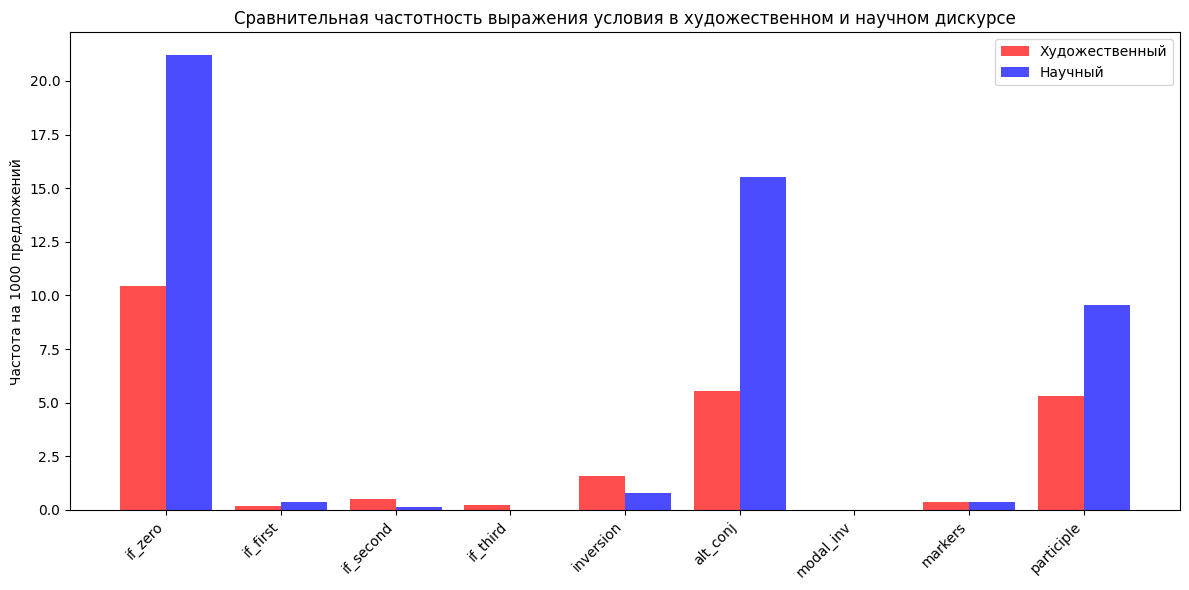

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(freq_fic.keys())
x = np.arange(len(labels))

fic_values = [freq_fic[l] for l in labels]
acad_values = [freq_ac[l] for l in labels]

width = 0.4

plt.figure(figsize=(12, 6))
bar1 = plt.bar(x - width/2, fic_values, width, label='Художественный', color='red', alpha=0.7)
bar2 = plt.bar(x + width/2, acad_values, width, label='Научный', color='blue', alpha=0.7)

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Частота на 1000 предложений')
plt.title('Сравнительная частотность выражения условия в художественном и научном дискурсе')

plt.legend()

plt.tight_layout()
plt.show()

Извлечение примеров

In [ ]:
samples = {ptype: {'fiction': [], 'acad': []} for ptype in patterns}

def collect_samples(sentences, category_key):
    for s in sentences:
        if not isinstance(s, str):
            continue
        for name, pat in patterns.items():
            if len(samples[name][category_key]) < 10 and pat.search(s):
                samples[name][category_key].append(s)
        if all(len(samples[name][category_key]) >= 10 for name in patterns):
            break

collect_samples(fiction_sents, 'fiction')
collect_samples(academ_sents, 'acad')

for name in patterns:
    print(f"\n=== {name} ===")
    print("Художественные примеры:")
    for sent in samples[name]['fiction']:
        print(f"- {sent}")
    print("\nНаучные примеры:")
    for sent in samples[name]['acad']:
        print(f"- {sent}")


=== if_zero ===
Fiction примеры:
- His teacher and his school principal were conferred with and everyone agreed that , if he kept up with a certain amount of work at home , there was little danger of his losing a term .
- If a branch extended out too far , each man held it back for the next , and if they met a low overhang , each warned the other .
- Congress is full of politicians , and if you want to get along with them , you have to be politic .
- I've got a quarter of a million Germans in my state , and those krautheads tune in on Father Werther every night , and if he tells them to go out and piss in the public square , that's what they do .
- If their schedules were to synchronize , there was no point in wasting time .
- When something unexpected happened , one always asked for water if one were a woman , brandy if one were a man .
- if he missed it , never again .
- It was a word he was proud of , a word that meant much to him , and he used it with great pleasure , almost as if